# Notebook d'avancement du code pour la simulation du modèle d'Ising
- Réécrire la fonction de convolution avec la FFT pour la rendre compatible avec Numba.
- Rendre la classe compatible avec Numba en explicitant les arguments ainsi que leurs types.
- Appliquer les conditions aux frontières périodiques (Pac-Man).
- Automatisation du code pour balayer différentes conditions $(T,\;h)$.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.ndimage as sc
import scipy.constants as cte
from matplotlib.animation import FuncAnimation

In [61]:
def initialize_lattice(size, pourcentage_up=0.70):
    """
    Initialise une grille avec un certain pourcentage de spins orienté up ou down.
    """
    # L'intervalle de densité uniforme de probabilité commence à -(1-pourcentage_up).
    uniform_interv_start = -1 * (1 - pourcentage_up)

    # L'intervalle finit à pourcentage_up.
    uniform_interv_stop = pourcentage_up
    
    # On retient le signe des nombres distribués aléatoirement dans l'intervalle.
    lattice = np.sign(np.random.uniform(uniform_interv_start, uniform_interv_stop, (size, size))) 

    return lattice

def extended_lattice(lattice): 
    """
    Applique les CF périodiques (Pac-Man) à la grille 2D.
    L'astuce repose sur l'ajout de bordures de 1 ligne/colonne autour de la grille. 
    La dimension effective de la grille est donc de (N+2) x (N+2). 
    """
    n = lattice.shape[0] # Taille de la grille

    lattice_extended = np.concatenate([lattice, lattice, lattice], axis=1)  # On applique les CF à gauche et à droite
    lattice_extended = np.concatenate([lattice_extended, lattice_extended, lattice_extended], axis=0)  # On applique les CF en haut et en bas.

    return lattice_extended[n-1:2*n+1, n-1:2*n+1] 

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

(12, 12)


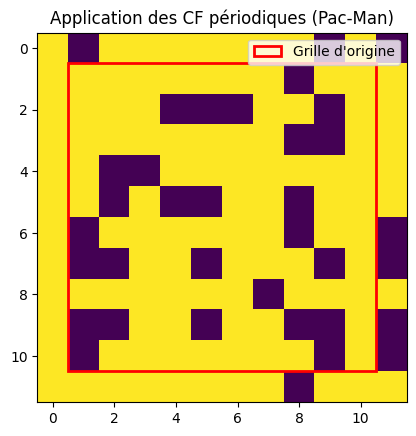

In [ ]:
n = 10

M0 = initialize_lattice(n)
M0_extended = extended_lattice(M0)
print(M0_extended.shape)
plt.imshow(M0_extended)
rect = plt.Rectangle((1-0.5, 1-0.5), n, n, edgecolor='red', facecolor='none', linewidth=2, label="Grille d'origine")
plt.gca().add_patch(rect)
plt.legend()
plt.title("Application des CF périodiques (Pac-Man)")
plt.show()

In [75]:
# La convolution revient à faire la somme sur les s_j, où j correspond aux plus proches voisins (du mask).
def convolution_2d_avec_fft(lattice, mask):
    """
    Effectue une convolution 2D en exploitant la FFT.
    Forme compatible avec une accélération par Numba.
    """
    # On effectue la transformée de Fourier des deux matrices.
    lattice_fourier = np.fft.fft2(lattice)
    mask_fourier = np.fft.fft2(np.flipud(np.fliplr(mask))) 

    # On multiplie les transformées dans le domaine fréquentiel.
    mask_fourier_padded = np.pad(mask_fourier, (lattice.shape[0]-3+1)//2)
    cc = np.real(np.fft.ifft2(lattice_fourier * mask_fourier_padded))  # Transformée inverse pour revenir dans l'espace réel

    # On centre le résultat.
    m, n = lattice.shape
    cc = np.roll(cc, -m // 2 + 1, axis=0)
    cc = np.roll(cc, -n // 2 + 1, axis=1)

    return cc

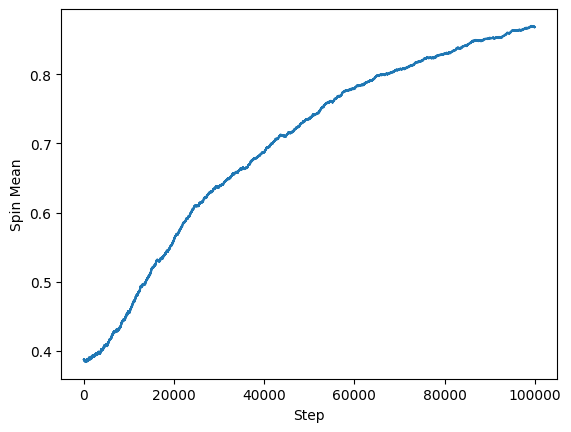

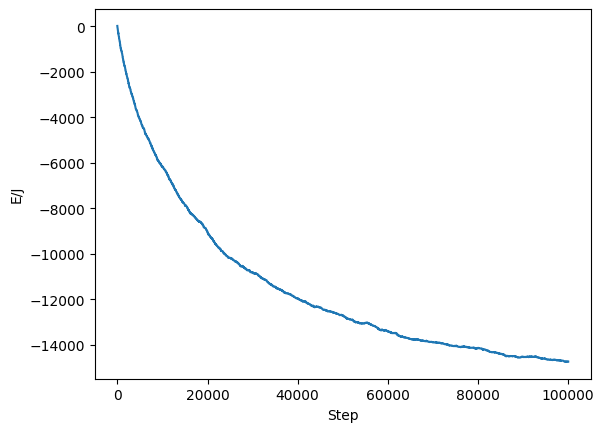

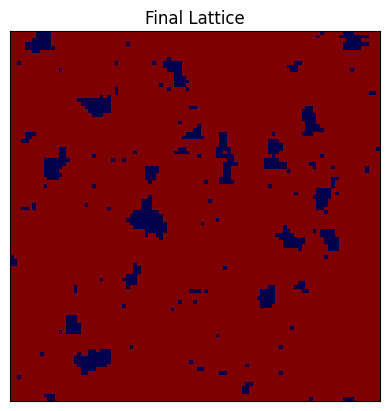

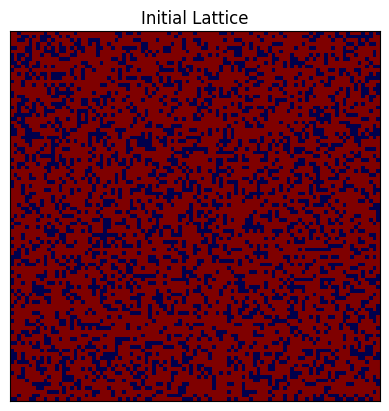

In [76]:
def microstate_energy(lattice, h):
    """
    Calcule l'énergie totale d'un micro-état donné (lattice : configuration de spins, h : composante Z du champ magnétique).

    On doit tenir compte de deux contributions : 
        1) les voisins immédiats;
        2) le champ magnétique externe.
    """

    energie_totale = 0 # Énergie totale nulle!

    # On commence par la contribution du champ magnétique externe.
    for i in range(len(lattice[0])):
        for j in range(len(lattice[0])):
            energie_totale -= h * lattice[i, j] # Signe (-) car si spin est dans la même direction que le champ, l'énergie est minimisée.

    #mask = sc.generate_binary_structure(2,1)  # Matrice 2D avec True seulement aux voisins plus proche (connectivité=1).
    mask = np.ones((3,3), dtype=int)  # Matrice 2D avec 1 seulement aux voisins plus proche (connectivité=1).
    mask[1,1] = 0  # Le spin est lui-même exclu de la somme.

    # Utilisation de la fonction convolution_2d_avec_fft pour calculer l'énergie des interactions.
    grille_etendue = extended_lattice(lattice)  # On applique les CF périodiques (Pac-Man)
    energies_interaction_vec = -lattice * convolution_2d_avec_fft(grille_etendue, mask)[1:lattice.shape[0]+1,1:lattice.shape[0]+1]

    return energie_totale + np.sum(energies_interaction_vec)  # 2 contributions à l'énergie : 1) champ magnétique; 2) spins voisins.

@numba.njit(nogil=True)
def find_equilibrium(betaJ, h,  lattice, n_iter, energy):
    # BetaJ vu q'on a normalisé. Revient à diviser par J dans la formule de l'énergie
    # On commence par définir une nouvelle grille où on a flippé un spin aléatoirement
    # Créer une copie de lattice en premier
    list_lattices = [lattice.copy()] # Probably une meilleure façon de le faire mais je met une liste de lattices pour faire l'animation plus tard. On peut pas mettre des trucs de matplotlib dans une foncion s'il y a numba
    spin_mean_list = [np.mean(lattice)]
    energy_list = [energy]
    for _ in range(n_iter):
        new_lattice = lattice.copy()
        row, col = np.random.randint(0, len(lattice[0])), np.random.randint(0, len(lattice[0]))
        new_lattice[row][col] *= -1 # Flip un spin au hasard
        # Terme dû au champ + terme de corrélation avec conditions frontières périodiques
        # On calcul seulement l'énergie du spin concerné puisque les autres ne changent pas
        E_i = -h * lattice[row, col] -  lattice[row, col] * (lattice[(row+1) % len(lattice), col] + lattice[(row-1) % len(lattice), col] + lattice[row, (col+1) % len(lattice)] + lattice[row, (col-1) % len(lattice)])
        E_f = -h * new_lattice[row, col] - new_lattice[row, col] * (new_lattice[(row+1) % len(lattice), col] + new_lattice[(row-1) % len(lattice), col] + new_lattice[row, (col+1) % len(lattice)] + new_lattice[row, (col-1) % len(lattice)])

        DeltaE = E_f - E_i
        if DeltaE > 0 and np.random.random() < np.exp(-betaJ*DeltaE):  # Si l'énergie du nouveau microétat est plus grande, on flip seulement avec la probabilité donnée par l'équation avec l'exponentielle
            lattice = new_lattice
            energy += DeltaE
        elif DeltaE <= 0:
            lattice = new_lattice  # Si l'énergie est plus petite on flip (100% de chance)
            energy += DeltaE
        spin_mean_list.append(np.mean(lattice))
        energy_list.append(energy)
        list_lattices.append(lattice)
    return list_lattices, energy, spin_mean_list, energy_list

initial_lattice = initialize_lattice(99)
energy = microstate_energy(initial_lattice, 0)
lattices, energy, spin_means, energy_list = find_equilibrium(0.7, 0, initial_lattice, 100000, energy) 
step_algo = np.arange(0, len(spin_means), 1)

plt.figure(1)
plt.plot(step_algo, spin_means)
plt.xlabel("Step")
plt.ylabel("Spin Mean")

plt.figure(2)
plt.plot(step_algo, energy_list)
plt.xlabel("Step")
plt.ylabel("E/J")

plt.figure(3)
plt.imshow(lattices[-1], vmin=-1, vmax=1, cmap="seismic")
plt.title("Final Lattice")
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(lattices[0], vmin=-1, vmax=1, cmap="seismic")
plt.title("Initial Lattice")
plt.xticks([])
plt.yticks([])
plt.show()

def animate_lattice(lattices, interval=1):
    fig, ax = plt.subplots()
    ax.set_title("Lattice Animation")
    ax.set_xticks([])
    ax.set_yticks([])

    # Function to update the lattice for each frame
    def update(frame):
        ax.clear()
        ax.set_title("Lattice Animation")
        ax.imshow(lattices[frame], vmin=-1, vmax=1, cmap="seismic")
        ax.set_xticks([])
        ax.set_yticks([])

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(lattices), interval=interval)
    plt.show()

#animate_lattice(lattices)
